<a href="https://colab.research.google.com/github/MayssenBHA/Oral-Diseases-Classification/blob/main/oral_detection_efficientnet_improveed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import the necessary library
import os
import shutil #copier les images d'un dossier vers un autre dossier
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18
from sklearn.utils.class_weight import compute_class_weight

**image copying**

In [ ]:

original_dirs = {
    'Calculus': '/content/drive/MyDrive/oral_diseases_classification/Oral Diseases Classification/Calculus',
    'Caries': '/content/drive/MyDrive/oral_diseases_classification/Oral Diseases Classification/Data caries',
    'Gingivitis': '/content/drive/MyDrive/oral_diseases_classification/Oral Diseases Classification/Gingivitis',
    'Ulcers': '/content/drive/MyDrive/oral_diseases_classification/Oral Diseases Classification/Mouth Ulcer',
    'Tooth Discoloration': '/content/drive/MyDrive/oral_diseases_classification/Oral Diseases Classification/Tooth Discoloration',
    'Hypodontia': '/content/drive/MyDrive/oral_diseases_classification/Oral Diseases Classification/hypodontia'
}

# Define the target base directory
base_dir = '/content/drive/MyDrive/oral_diseases_classification/Oral Diseases Classification'
splits = ['train', 'val', 'test']
classes = list(original_dirs.keys())

# Check if target directories already exist
train_dir_exists = os.path.exists(os.path.join(base_dir, 'train', classes[0]))
val_dir_exists = os.path.exists(os.path.join(base_dir, 'val', classes[0]))
test_dir_exists = os.path.exists(os.path.join(base_dir, 'test', classes[0]))

if not all([train_dir_exists, val_dir_exists, test_dir_exists]):
    # Create target directories if they don't exist
    for split in splits:
        for class_name in classes:
            os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

    # Initialize dictionaries to hold the counts for train, val, and test sets
    class_split_counts = {class_name: {'train': 0, 'val': 0, 'test': 0} for class_name in classes}

    # Function to copy images to the target directory and count them
    def copy_and_count_images(class_name, image_paths):
        # Split the data
        train_paths, test_paths = train_test_split(image_paths, test_size=0.1, random_state=42)
        train_paths, val_paths = train_test_split(train_paths, test_size=0.2, random_state=42)

        # Define split mappings
        split_paths = {
            'train': train_paths,
            'val': val_paths,
            'test': test_paths
        }

        # Copy images to their respective directories and count them
        for split, paths in split_paths.items():
            class_split_counts[class_name][split] = len(paths)
            for img_path in paths:
                target_path = os.path.join(base_dir, split, class_name, os.path.basename(img_path))
                shutil.copy(img_path, target_path)

    # Traverse the original directories and gather image paths
    for class_name, original_dir in original_dirs.items():
        image_paths = []
        for root, dirs, files in os.walk(original_dir):
            image_paths.extend([os.path.join(root, file) for file in files if file.endswith(('.jpg', '.jpeg', '.png'))])
        if image_paths:
            copy_and_count_images(class_name, image_paths)

    print("Images have been copied and organized successfully.")
else:
    print("Directories already exist. Skipping image copying.")

Directories already exist. Skipping image copying.


**Data Visualization :** 3 images per class

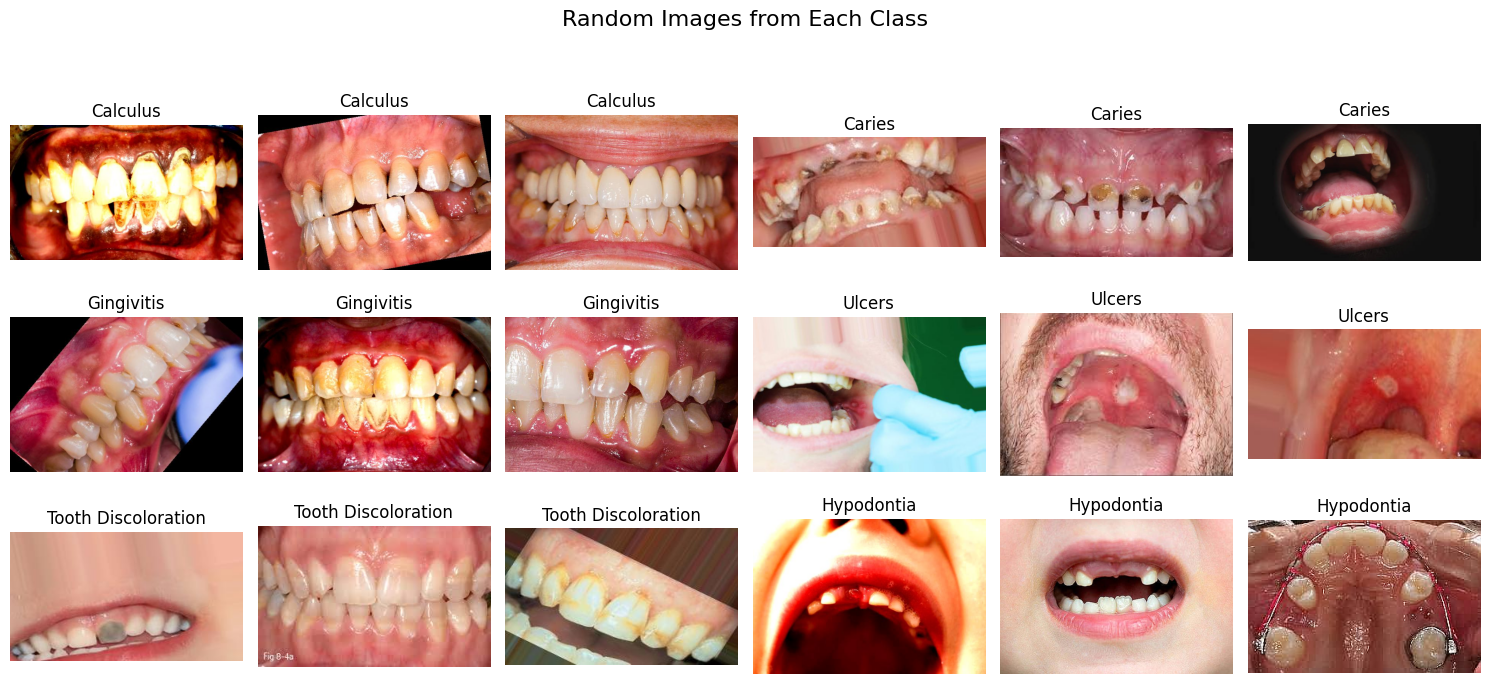

In [ ]:
# Number of images to display per class and per row
num_images_per_class = 3
num_images_per_row = 6

# Set seed for reproducibility
random.seed(42)

# Function to get random images from a directory
def get_random_images_from_dir(directory, num_images):
    all_images = [os.path.join(directory, img) for img in os.listdir(directory) if img.endswith(('.jpg', '.jpeg', '.png'))]
    if len(all_images) < num_images:
        return all_images
    return random.sample(all_images, num_images)

# Create a figure
num_rows = (len(classes) * num_images_per_class + num_images_per_row - 1) // num_images_per_row  # Calculate number of rows needed
fig, axs = plt.subplots(num_rows, num_images_per_row, figsize=(15, num_rows * 2.5))
fig.suptitle('Random Images from Each Class', fontsize=16)

# Flatten axs array for easier indexing
axs = axs.flatten()

# Iterate through classes and display images
image_idx = 0
for class_name in classes:
    class_dir = os.path.join(base_dir, 'train', class_name)
    random_images = get_random_images_from_dir(class_dir, num_images_per_class)

    for img_path in random_images:
        if image_idx < len(axs):
            img = Image.open(img_path)
            ax = axs[image_idx]
            ax.imshow(img)
            ax.set_title(class_name)
            ax.axis('off')
            image_idx += 1

# Hide any unused subplots
for i in range(image_idx, len(axs)):
    axs[i].axis('off')

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Data distribution visualization**

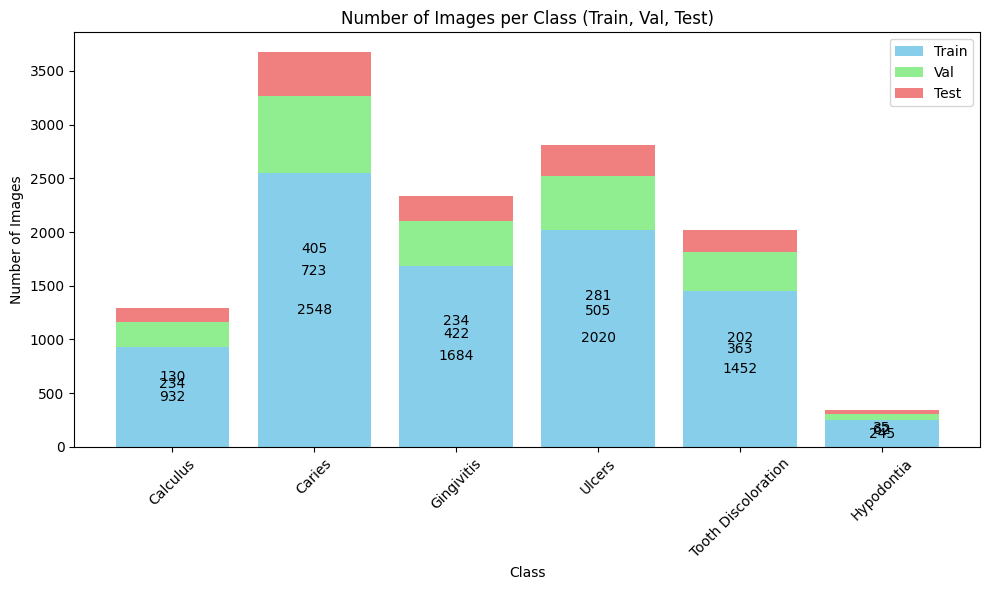

In [ ]:
# Initialize dictionaries to hold the counts for train, val, and test sets
class_split_counts = {class_name: {'train': 0, 'val': 0, 'test': 0} for class_name in classes}

# Function to count images in each split
def count_images(base_dir, class_name):
    counts = {}
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(base_dir, split, class_name)
        counts[split] = len(os.listdir(split_dir))
    return counts

# Calculate counts for each class and split
for class_name in classes:
    class_split_counts[class_name] = count_images(base_dir, class_name)

# Create lists for the bar plot
labels = classes
train_counts = [class_split_counts[class_name]['train'] for class_name in classes]
val_counts = [class_split_counts[class_name]['val'] for class_name in classes]
test_counts = [class_split_counts[class_name]['test'] for class_name in classes]

x = range(len(classes))

# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(x, train_counts, label='Train', color='skyblue')
bar2 = ax.bar(x, val_counts, bottom=train_counts, label='Val', color='lightgreen')
bar3 = ax.bar(x, test_counts, bottom=[i+j for i,j in zip(train_counts, val_counts)], label='Test', color='lightcoral')

ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class (Train, Val, Test)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

# Add data labels
for bar in bar1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval / 2, int(yval), ha='center', va='center', color='black')

for bar in bar2:
    yval = bar.get_height() + bar.get_y()
    ax.text(bar.get_x() + bar.get_width()/2, yval / 2, int(bar.get_height()), ha='center', va='center', color='black')

for bar in bar3:
    yval = bar.get_height() + bar.get_y()
    ax.text(bar.get_x() + bar.get_width()/2, yval / 2, int(bar.get_height()), ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

In [ ]:
# Define directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Parameters
image_size = (128, 128)
batch_size = 32
num_epochs = 25

unbalanced data : for exemple the Ulcers training data is 1828 image while the Calculus is only 932 images wich is a huge difference so we need to hundle this problem maybe with data augmentation

In [ ]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    #########################
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    # transforms.RandomAffine(degrees=0, shear=0.1),
    #########################
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Normalization for validation and testing
val_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


In [ ]:
# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)#yekhou tsawer lkol ml dossier eli path mte3ou train_dir w baad yaamlelha data augmentation
val_dataset = ImageFolder(val_dir, transform=val_transforms)
test_dataset = ImageFolder(test_dir, transform=val_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
!pip install --upgrade certifi

import ssl
import certifi

ssl._create_default_https_context = ssl._create_unverified_context

**creating the model : EfficientNet**

In [ ]:
# Get number of classes
num_classes = len(train_dataset.classes)

import torch.nn as nn
import torchvision.models as models

class EfficientNetModel(nn.Module):
    def __init__(self):
        super(EfficientNetModel, self).__init__()
        # Use EfficientNet B0 - good balance of accuracy and speed
        self.backbone = models.efficientnet_b0(weights='IMAGENET1K_V1')

        # Get the number of features from the backbone
        in_features = self.backbone.classifier[1].in_features

        # Replace classifier
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.5, inplace=True),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            # Removing BatchNorm1d to handle batch size of 1
            # nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# Initialize model and optimizer
model = EfficientNetModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


####################
# Compute initial class weights
class_weights = compute_class_weight(class_weight="balanced",
                                    classes=np.unique(train_dataset.targets),
                                    y=train_dataset.targets)


######################################
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


# Use learning rate scheduler and better optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=2e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Keep your class weight handling
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 39.4MB/s]


In [ ]:
# Set environment variable to avoid threading issues
os.environ["OMP_NUM_THREADS"] = "1"

# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Early stopping parameters
early_stopping = True
patience = 3  # Number of epochs to wait if no improvement is observed

# Initialize early stopping variables
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Initialize lists to store losses, accuracies, and learning rates
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Variables to store y_true and y_scores for precision-recall calculation
y_true = []
y_scores = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_true = []
    val_outputs = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_true.extend(labels.cpu().numpy())
            val_outputs.extend(outputs.cpu().numpy())

    val_loss = val_loss / len(val_dataset)
    val_acc = accuracy_score(val_true, val_preds)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Append true labels and predicted scores for precision-recall calculation
    y_true.extend(val_true)
    y_scores.extend(val_outputs)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Check for improvement in validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the model checkpoint here if you want

    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping after {epoch+1} epochs.')
            early_stop = True
            break

    # LR scheduler step based on validation loss
    scheduler.step(val_loss)

    if early_stop:
        break



/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/25], Train Loss: 1.3256, Val Loss: 1.1889, Val Acc: 0.7951


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [2/25], Train Loss: 1.0585, Val Loss: 1.0986, Val Acc: 0.8441


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [3/25], Train Loss: 0.9767, Val Loss: 1.0700, Val Acc: 0.8489


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [4/25], Train Loss: 0.9346, Val Loss: 1.0512, Val Acc: 0.8601


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [5/25], Train Loss: 0.9073, Val Loss: 1.0255, Val Acc: 0.8649


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [6/25], Train Loss: 0.8910, Val Loss: 1.0109, Val Acc: 0.8753


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [7/25], Train Loss: 0.8842, Val Loss: 1.0216, Val Acc: 0.8722


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [8/25], Train Loss: 0.8714, Val Loss: 1.0280, Val Acc: 0.8631


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [9/25], Train Loss: 0.8683, Val Loss: 1.0267, Val Acc: 0.8623
Early stopping after 9 epochs.


**Model evaluation**

In [ ]:
# Test the model
model.eval()
test_preds = []
test_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_true.extend(labels.cpu().numpy())

test_acc = accuracy_score(test_true, test_preds)
print(f'Test Accuracy: {test_acc:.4f}')

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 0.8765


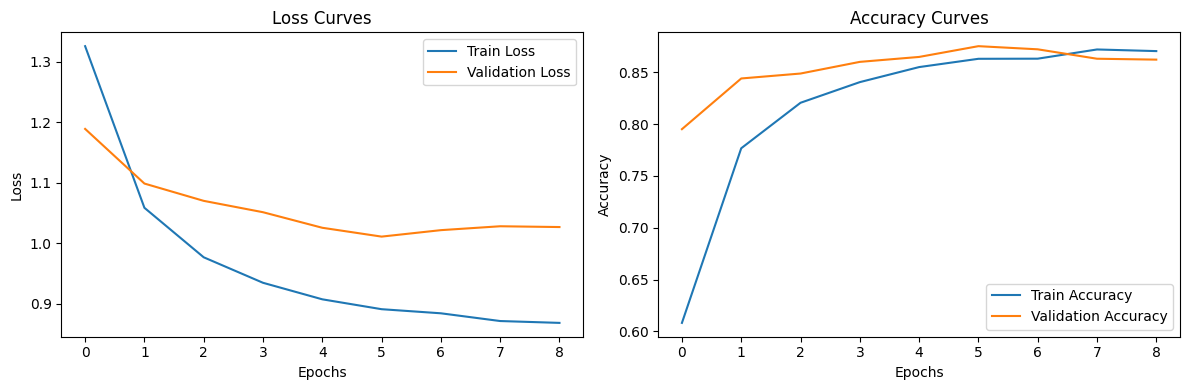

In [ ]:
# Plotting loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plotting loss
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting accuracy
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Generate classification report
class_names = test_dataset.classes
report = classification_report(test_true, test_preds, target_names=class_names)

# Display classification report
print("Classification Report:")
print(report)

Classification Report:
                     precision    recall  f1-score   support

           Calculus       0.61      0.93      0.74       130
             Caries       0.97      0.83      0.89       405
         Gingivitis       0.86      0.71      0.78       234
         Hypodontia       0.92      0.97      0.94        35
Tooth Discoloration       0.90      0.98      0.94       202
             Ulcers       0.93      0.98      0.95       281

           accuracy                           0.88      1287
          macro avg       0.87      0.90      0.87      1287
       weighted avg       0.89      0.88      0.88      1287



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


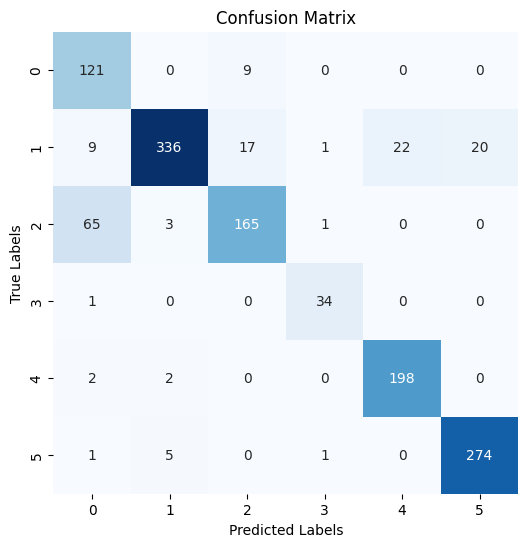

In [ ]:
# Get predictions for the test set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()